In [15]:
import pygris
import matplotlib.pyplot
from matplotlib_map_utils import north_arrow

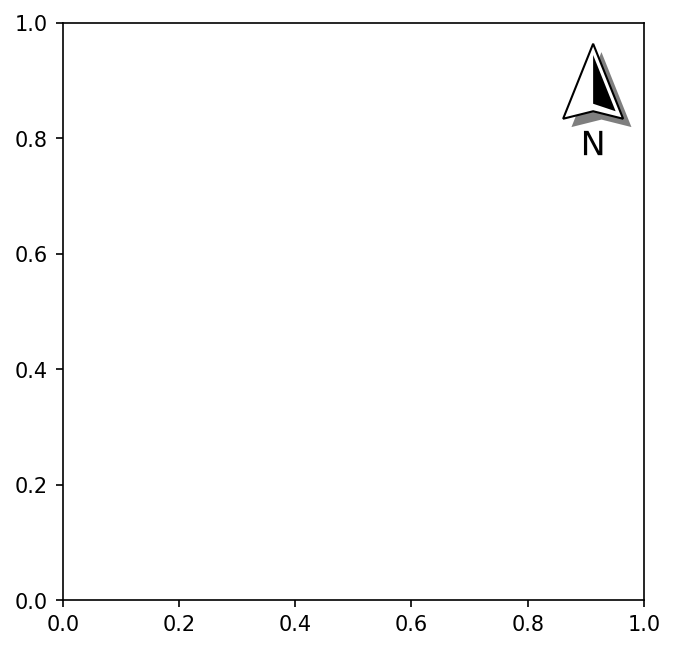

In [13]:
# README north arrow plot

# Setting up a plot
fig, ax = matplotlib.pyplot.subplots(1,1, figsize=(5,5), dpi=150)
# Adding a north arrow to the upper-right corner of the axis, without any rotation (see Rotation under Formatting Components for details)
north_arrow.north_arrow(ax=ax, location="upper right", rotation={"degrees":0})

matplotlib.pyplot.savefig("./readme_northarrow.png")

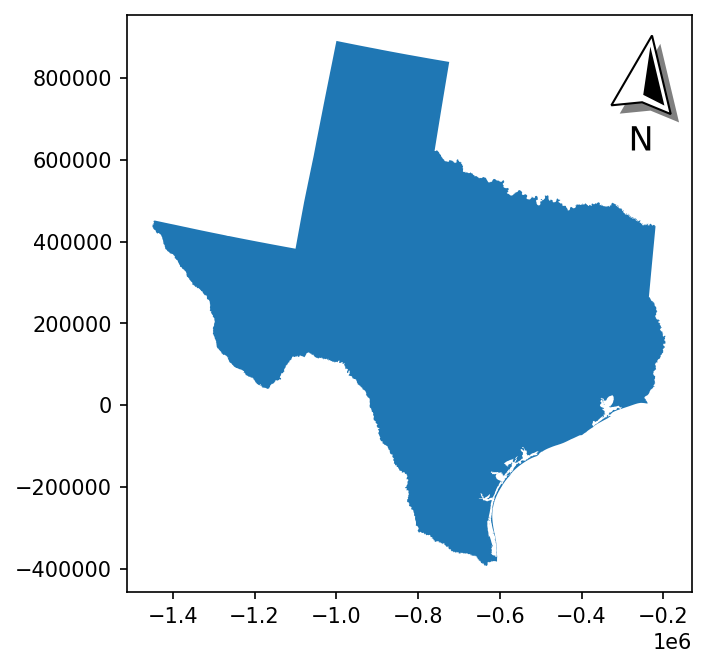

In [17]:
# README north arrow rotation
states = pygris.states(cb=True, year=2022, cache=False).to_crs(3857)
# Setting up a plot
fig, ax = matplotlib.pyplot.subplots(1,1, figsize=(5,5), dpi=150)
# Plotting a state (Georgia)
states.query("NAME=='Texas'").to_crs(3520).plot(ax=ax)
# Adding a north arrow to the upper-right corner of the axis, without any rotation (see Rotation under Formatting Components for details)
north_arrow.north_arrow(ax=ax, location="upper right", rotation={"crs":3520, "reference":"center"})

matplotlib.pyplot.savefig("./readme_northarrow_rotation.png")